In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import train
import pickle


In [8]:
dfList = train.transform()
#df.shape

In [9]:
df1List = dfList
dfList = df1List
for df in dfList:
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
    df = scaler.transform(df)
#print(dfList[12])
#print(dfList[0].head(5))

In [10]:
def eval(accList, precisionList, tprList, farList, frrList, y, y_pred):
    avgaccuracy = 0
    avgPrecision = 0
    avgTpr = 0
    avgFar = 0
    avgFrr = 0
    for i in range(len(accList)):
        avgaccuracy += accList[i]
        avgPrecision += precisionList[i]
        avgTpr += tprList[i]
        avgFar += farList[i]
        avgFrr += frrList[i]
    avgaccuracy = avgaccuracy / len(accList)
    avgPrecision = avgPrecision / len(precisionList)
    avgTpr = avgTpr / len(tprList)
    avgFar = avgFar / len(farList)
    avgFrr = avgFrr / len(frrList)
    
    fprROC, tprROC, threshold = roc_curve(y, y_pred, pos_label=1) #fprROC == avgFar, tprROC == avgTpr
    fnrROC = 1 - tprROC #fnrROC == avgFrr
    EER = fprROC[np.nanargmin(np.absolute((fnrROC - fprROC)))]

    print("average acc = "+str(avgaccuracy))
    print("average precision = "+str(avgPrecision))
    print("average TPR = "+str(avgTpr))
    print("average FAR = "+str(avgFar))
    print("average FRR = "+str(avgFrr))
    print("average EER = "+str(EER))

In [11]:
#Truly train the RF models that are going to be used

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

i=0
for df in dfList: 
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['sizeMedian'])
    y = df['label']
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y) #stratify=y means to keep the same ratio of labels in test set as the training set
    X_re, y_re = SMOTE(random_state=42, k_neighbors=2).fit_resample(X_train, y_train.astype('int')) #only apply SMOTE on training dataset
    #print(X_train.shape)
    #print(X_re.shape)
    #k_fold = KFold(5, shuffle=True, random_state=42)
    '''
    for train_ix, test_ix in k_fold.split(X):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]    

        
    
        RF = RandomForestClassifier(n_estimators=22)

        RF.fit(X_re,y_re)
    #model.fit(X_train, y_train.astype('int'))
        y_pred = RF.predict(X_test)
        predicted_targets = np.append(predicted_targets, y_pred)
        actual_targets = np.append(actual_targets, y_test)
    '''
    RF_model = RandomForestClassifier(n_estimators=22)
    RF_model.fit(X_re,y_re)
    
    import pickle
    pickle.dump(RF_model, open(f"./models/rf{i}.pickle", "wb"))
    
    y_pred = RF_model.predict(X_test)
    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)
    
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets)
    '''
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()
    '''
    
    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)
    
    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)
    
    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))

    initial_types = [
        ('input_data_type', FloatTensorType([None, 54]))
    ]

    converted_model = convert_sklearn(RF_model, initial_types=initial_types)
    with open(f"./models/model{i}.onnx", "wb") as f:
        f.write(converted_model.SerializeToString())
    i+=1
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)
'''
plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()
'''

acc = 0.9977802441731409
precision = 1.0
TPR = 0.9615384615384616
FAR = 0.0
FRR = 0.038461538461538464
acc = 0.9955604883462819
precision = 0.9411764705882353
TPR = 0.9795918367346939
FAR = 0.0035211267605633804
FRR = 0.02040816326530612
acc = 0.9955604883462819
precision = 0.9387755102040817
TPR = 0.9787234042553191
FAR = 0.00351288056206089
FRR = 0.02127659574468085
acc = 0.9977802441731409
precision = 0.9583333333333334
TPR = 1.0
FAR = 0.0023391812865497076
FRR = 0.0
acc = 0.9877913429522752
precision = 0.9230769230769231
TPR = 0.8181818181818182
FAR = 0.003500583430571762
FRR = 0.18181818181818182
acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0
acc = 0.9889012208657048
precision = 0.9487179487179487
TPR = 0.8222222222222222
FAR = 0.002336448598130841
FRR = 0.17777777777777778
acc = 0.9977802441731409
precision = 0.9545454545454546
TPR = 1.0
FAR = 0.002328288707799767
FRR = 0.0
acc = 0.9944506104328524
precision = 0.9444444444444444
TPR = 0.918918918918919
FAR = 0.0023148148

"\nplt.figure(figsize=(12,5))\nsns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)\nplt.xlabel('Pred',fontsize=20)\nplt.ylabel('True',fontsize=20)\nplt.show()\n"

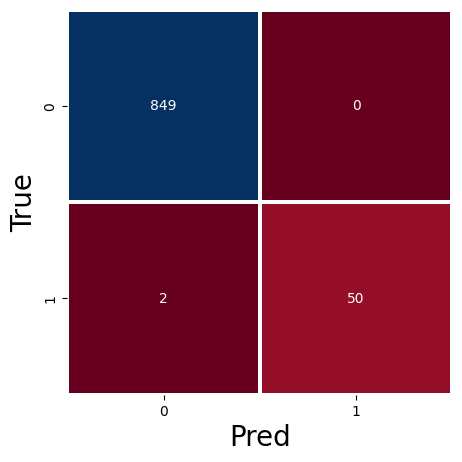

acc = 0.9977802441731409
precision = 1.0
TPR = 0.9615384615384616
FAR = 0.0
FRR = 0.038461538461538464


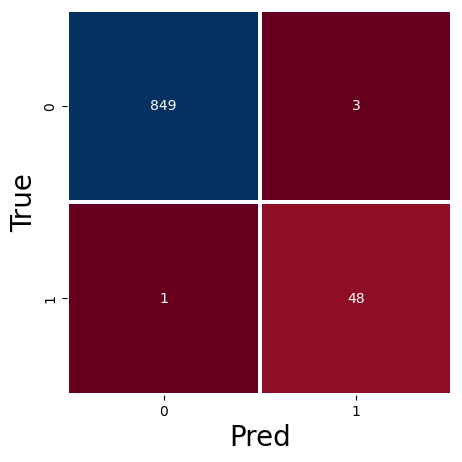

acc = 0.9955604883462819
precision = 0.9411764705882353
TPR = 0.9795918367346939
FAR = 0.0035211267605633804
FRR = 0.02040816326530612


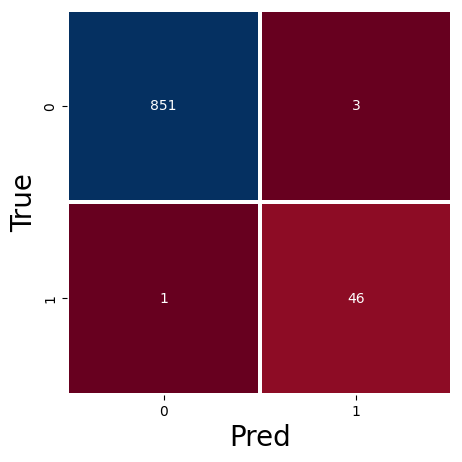

acc = 0.9955604883462819
precision = 0.9387755102040817
TPR = 0.9787234042553191
FAR = 0.00351288056206089
FRR = 0.02127659574468085


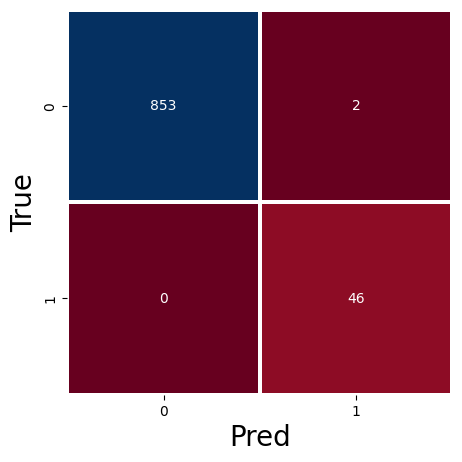

acc = 0.9977802441731409
precision = 0.9583333333333334
TPR = 1.0
FAR = 0.0023391812865497076
FRR = 0.0


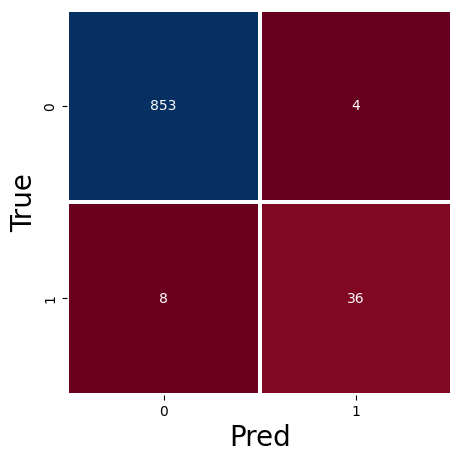

acc = 0.9866814650388457
precision = 0.9
TPR = 0.8181818181818182
FAR = 0.004667444574095682
FRR = 0.18181818181818182


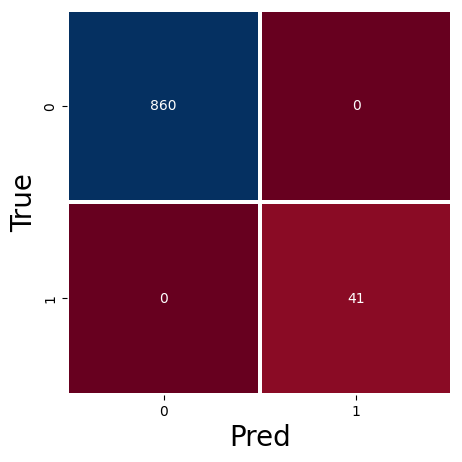

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0


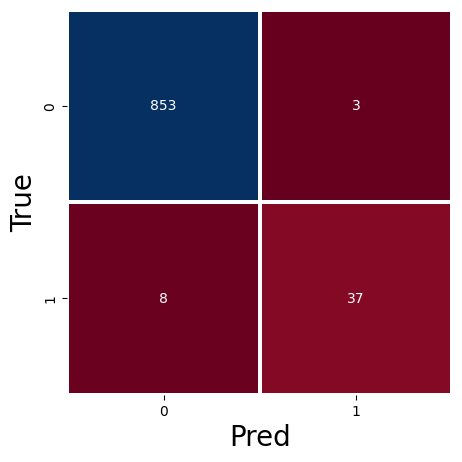

acc = 0.9877913429522752
precision = 0.925
TPR = 0.8222222222222222
FAR = 0.0035046728971962616
FRR = 0.17777777777777778


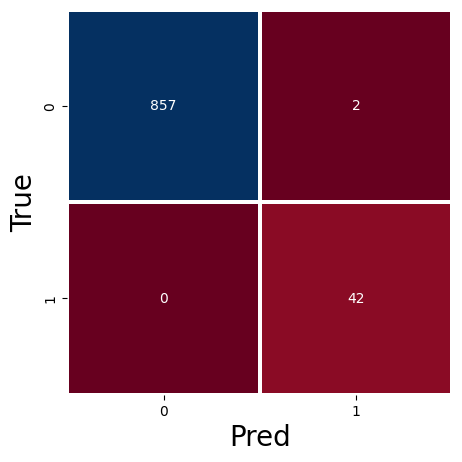

acc = 0.9977802441731409
precision = 0.9545454545454546
TPR = 1.0
FAR = 0.002328288707799767
FRR = 0.0


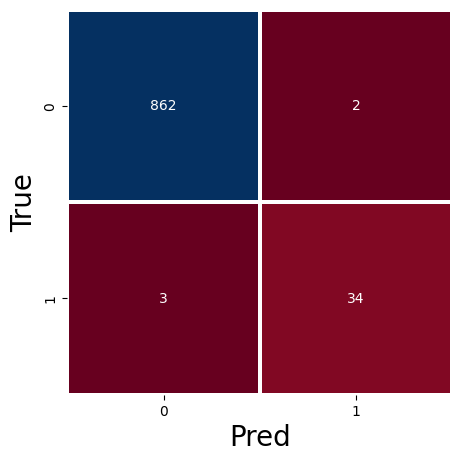

acc = 0.9944506104328524
precision = 0.9444444444444444
TPR = 0.918918918918919
FAR = 0.0023148148148148147
FRR = 0.08108108108108109


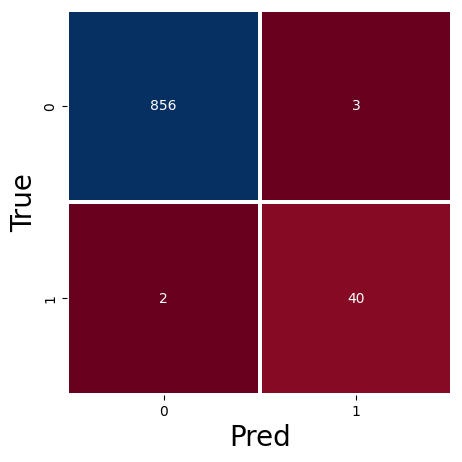

acc = 0.9944506104328524
precision = 0.9302325581395349
TPR = 0.9523809523809523
FAR = 0.0034924330616996507
FRR = 0.047619047619047616


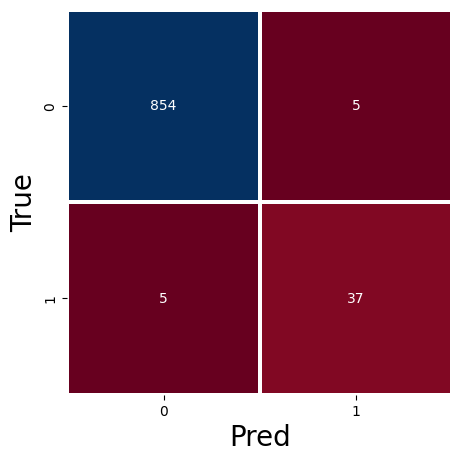

acc = 0.9889012208657048
precision = 0.8809523809523809
TPR = 0.8809523809523809
FAR = 0.005820721769499418
FRR = 0.11904761904761904


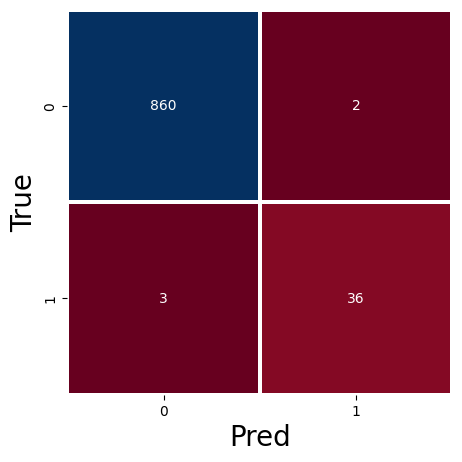

acc = 0.9944506104328524
precision = 0.9473684210526315
TPR = 0.9230769230769231
FAR = 0.002320185614849188
FRR = 0.07692307692307693


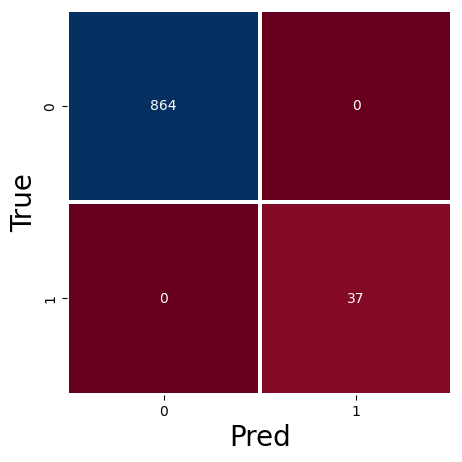

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0


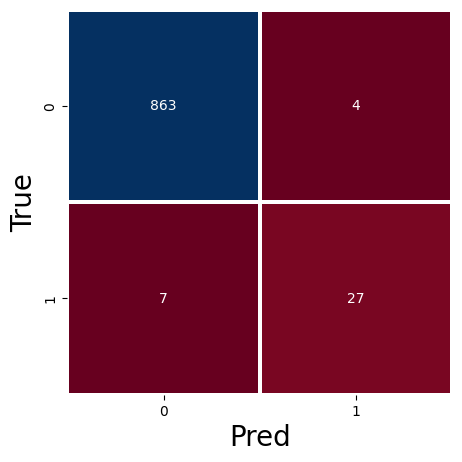

acc = 0.9877913429522752
precision = 0.8709677419354839
TPR = 0.7941176470588235
FAR = 0.00461361014994233
FRR = 0.20588235294117646


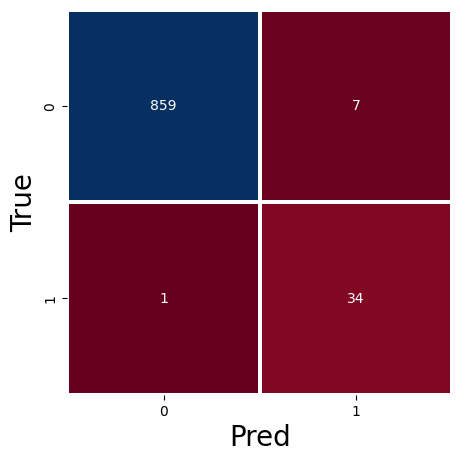

acc = 0.9911209766925638
precision = 0.8292682926829268
TPR = 0.9714285714285714
FAR = 0.008083140877598153
FRR = 0.02857142857142857


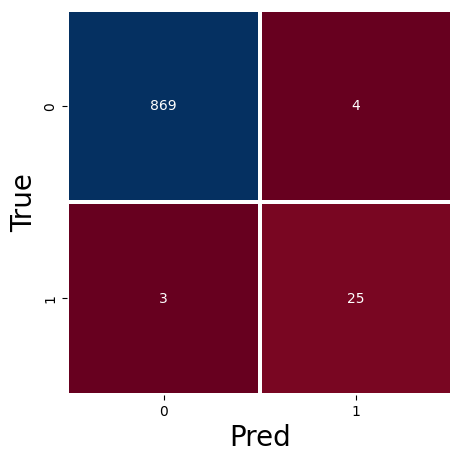

acc = 0.9922308546059934
precision = 0.8620689655172413
TPR = 0.8928571428571429
FAR = 0.004581901489117984
FRR = 0.10714285714285714


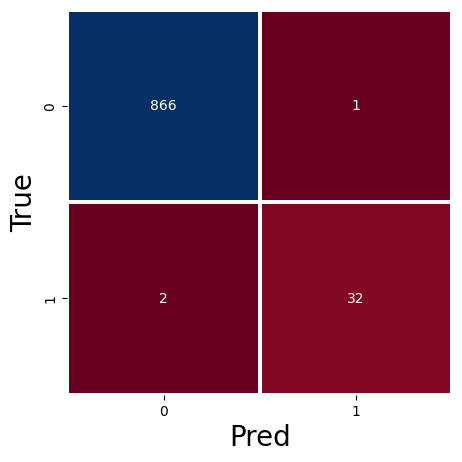

acc = 0.9966703662597114
precision = 0.9696969696969697
TPR = 0.9411764705882353
FAR = 0.0011534025374855825
FRR = 0.058823529411764705


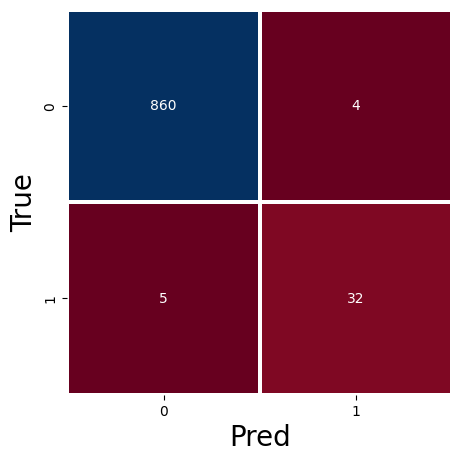

acc = 0.9900110987791343
precision = 0.8888888888888888
TPR = 0.8648648648648649
FAR = 0.004629629629629629
FRR = 0.13513513513513514


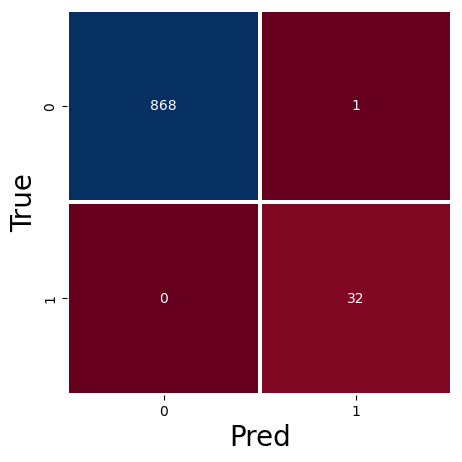

acc = 0.9988901220865705
precision = 0.9696969696969697
TPR = 1.0
FAR = 0.0011507479861910242
FRR = 0.0


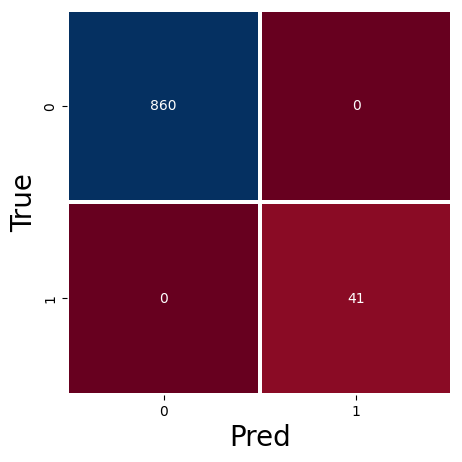

acc = 1.0
precision = 1.0
TPR = 1.0
FAR = 0.0
FRR = 0.0


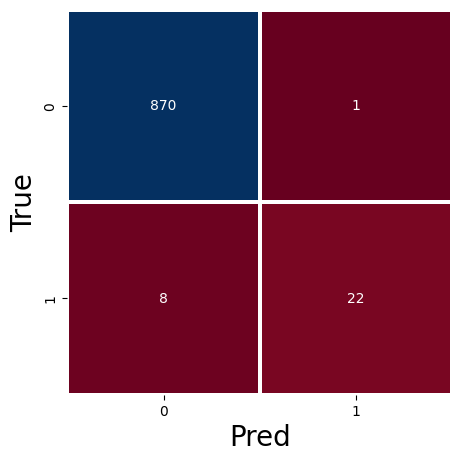

acc = 0.9900110987791343
precision = 0.9565217391304348
TPR = 0.7333333333333333
FAR = 0.001148105625717566
FRR = 0.26666666666666666


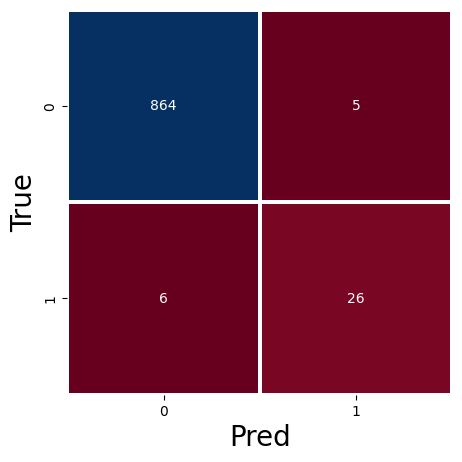

acc = 0.9877913429522752
precision = 0.8387096774193549
TPR = 0.8125
FAR = 0.005753739930955121
FRR = 0.1875


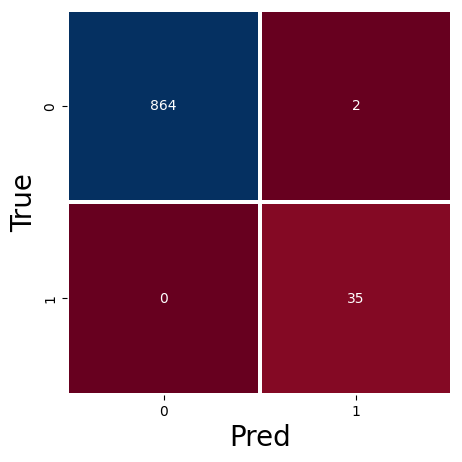

acc = 0.9977802441731409
precision = 0.9459459459459459
TPR = 1.0
FAR = 0.0023094688221709007
FRR = 0.0
average acc = 0.9940645659412247
average precision = 0.932721468007579
average TPR = 0.923733258625768
average FAR = 0.0029237172651276977
average FRR = 0.07626674137423209
average EER = 0.0023094688221709007


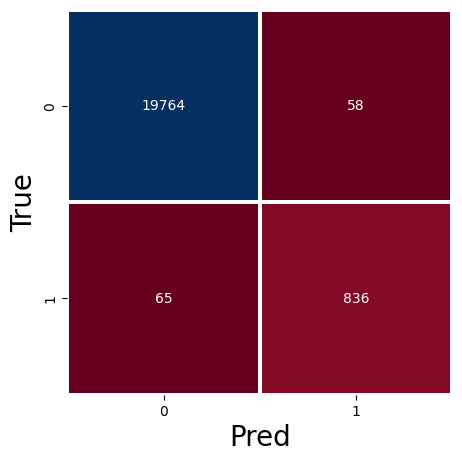

In [12]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt

precisionList = []
accList = []
tprList = []
farList = []
frrList = []
tnTotal, fpTotal, fnTotal, tpTotal = 0, 0, 0, 0

i=0
for df in dfList: 
    X = df.drop(columns=['label'])
    X = X.drop(columns=['pressureMedian'])
    X = X.drop(columns=['sizeMedian'])
    y = df['label']
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y) #stratify=y means to keep the same ratio of labels in test set as the training set
    '''
    k_fold = KFold(5, shuffle=True, random_state=42)
    for train_ix, test_ix in k_fold.split(X):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]    

        #X_re, y_re = SMOTE(random_state=42, k_neighbors=2).fit_resample(X_train, y_train.astype('int')) #only apply SMOTE on training dataset
    
        sess = rt.InferenceSession(
            f"./models/model{i}.onnx", providers=rt.get_available_providers())
        input_name = sess.get_inputs()[0].name
        #print(X_test.astype(np.float32).to_dict('split')['data'])
        #break
        y_pred = sess.run(None, {input_name: X_test.astype(np.float32).to_dict('split')['data']})[0]

        predicted_targets = np.append(predicted_targets, y_pred)
        actual_targets = np.append(actual_targets, y_test)
    
    i+=1
    '''
    
    sess = rt.InferenceSession(
            f"./models/model{i}.onnx", providers=rt.get_available_providers())
    input_name = sess.get_inputs()[0].name
        #print(X_test.astype(np.float32).to_dict('split')['data'])
        #break
    y_pred = sess.run(None, {input_name: X_test.astype(np.float32).to_dict('split')['data']})[0]
    i+=1
    predicted_targets = np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)
    
    cm = confusion_matrix(actual_targets.astype('int'), predicted_targets)
    plt.figure(figsize=(12,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()
    
    tn, fp, fn, tp = cm.ravel()
    tnTotal += tn
    fpTotal += fp
    fnTotal += fn
    tpTotal += tp
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    tpr = tp/(tp+fn)
    far = fp/(fp+tn)
    frr = fn/(fn+tp)
    
    accList.append(accuracy)
    precisionList.append(precision)
    tprList.append(tpr)
    farList.append(far)
    frrList.append(frr)
    
    print("acc = "+str(accuracy))
    print("precision = "+str(precision))
    print("TPR = "+str(tpr))
    print("FAR = "+str(far))
    print("FRR = "+str(frr))
    
eval(accList, precisionList, tprList, farList, frrList, actual_targets.astype('int'), predicted_targets)
plt.figure(figsize=(12,5))
sns.heatmap(np.array([[tnTotal, fpTotal], [fnTotal, tpTotal]]),square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()
